### Introduction 

Dans le contexte actuel de marchés financiers caractérisés par une volatilité accrue et des incertitudes géopolitiques, la gestion des risques et l'optimisation des rendements deviennent des priorités absolues pour les investisseurs et les traders. Les options, en particulier les stratégies de vente de volatilité, offrent des opportunités pour naviguer dans cet environnement complexe. Ces stratégies permettent non seulement de capitaliser sur des conditions de marché spécifiques, mais elles sont particulièrement adaptées dans des contextes non directionnels.

J'ai trouvé intéressant d'explorer, d'analyser et de proposer des stratégies optionnelles capables d'apporter une valeur ajoutée tangible à notre équipe pour qu'ensuite elles puissent être proposées aux clients.

Ce rapport a pour objectif de présenter une série de stratégies de vente de volatilité adaptées aux options sur les obligations souveraines allemandes à court terme (Schatz). Ces stratégies seront évaluées à travers des backtests sur une période d'un an.

#### Importation des données :

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


df = pd.read_csv('Prix_DU.csv', delimiter=';')

df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y')

# supprimer la 3ème colonne
df = df.drop(columns=['Unnamed: 2'])

# on prend que à partie de 2023
df = df[df['Date'] > '2023-01-01']

#### Nettoyage + plot des données :

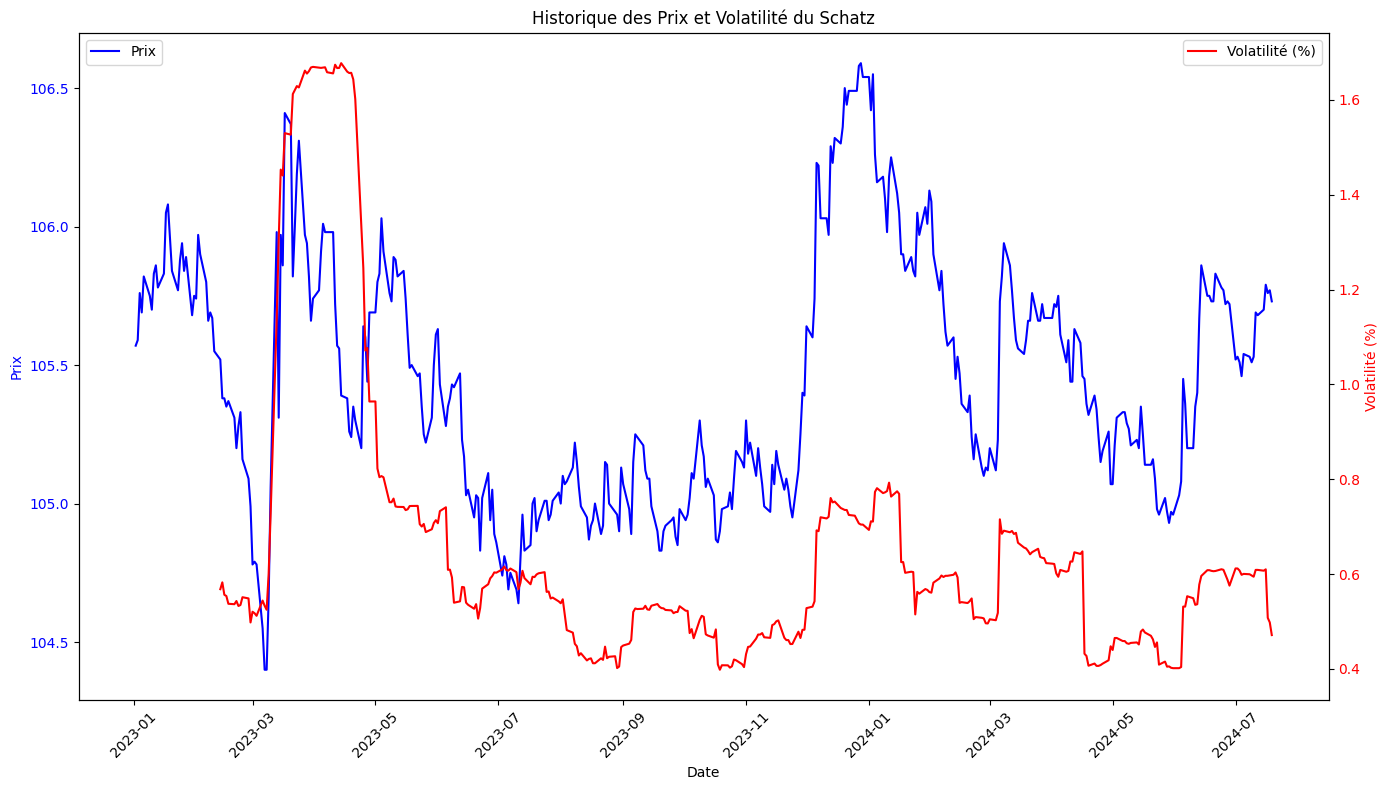

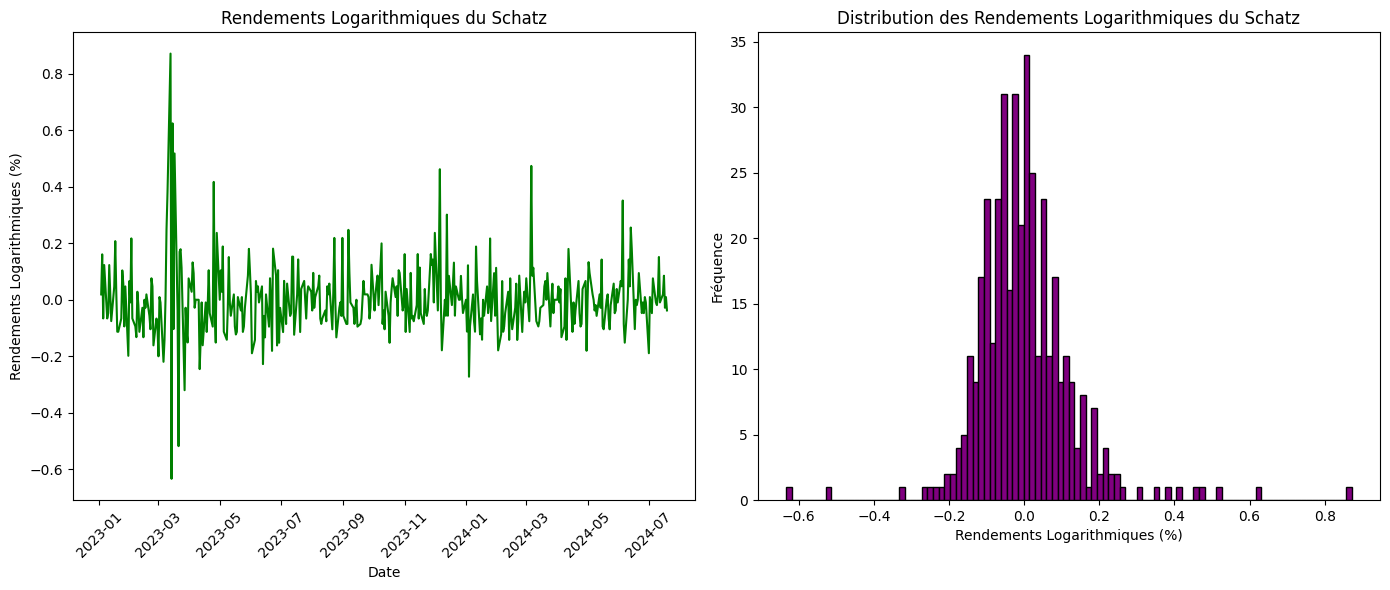

In [35]:
# rendements log
df['Log_Returns'] = np.log(df['Bid'] / df['Bid'].shift(1))

# Volatilité historique (30j)
window_size = 30
df['Volatility'] = df['Log_Returns'].rolling(window=window_size).std() * np.sqrt(window_size) * 100

df['Log_Returns_Percentage'] = df['Log_Returns'] * 100


fig, ax1 = plt.subplots(figsize=(14, 8))

ax1.plot(df['Date'], df['Bid'], color='blue', label='Prix')
ax1.set_xlabel('Date')
ax1.set_ylabel('Prix', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.legend(loc='upper left')
ax1.set_title('Historique des Prix et Volatilité du Schatz')
ax1.tick_params(axis='x', rotation=45)

ax2 = ax1.twinx()
ax2.plot(df['Date'], df['Volatility'], color='red', label='Volatilité (%)')
ax2.set_ylabel('Volatilité (%)', color='red')
ax2.tick_params(axis='y', labelcolor='red')
ax2.legend(loc='upper right')

fig.tight_layout()
plt.show()


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

ax1.plot(df['Date'], df['Log_Returns_Percentage'], color='green')
ax1.set_xlabel('Date')
ax1.set_ylabel('Rendements Logarithmiques (%)')
ax1.set_title('Rendements Logarithmiques du Schatz')
ax1.tick_params(axis='x', rotation=45)

ax2.hist(df['Log_Returns_Percentage'].dropna(), bins=100, edgecolor='black', color='purple')
ax2.set_xlabel('Rendements Logarithmiques (%)')
ax2.set_ylabel('Fréquence')
ax2.set_title('Distribution des Rendements Logarithmiques du Schatz')

fig.tight_layout()
plt.show()


### Stratégies de Vente de Volatilité

#### Short Straddle

**Définition :**
Le short straddle consiste à vendre simultanément une option call et une option put avec le même prix d'exercice et la même date d'expiration. Cette stratégie est mise en place lorsque l'on s'attend à une faible volatilité de l'actif sous-jacent.

**Mécanisme :**
- **Entrée en position :** Vente d'une option call et d'une option put au prix d'exercice actuel (at-the-money).
- **Objectif :** Capturer la prime totale reçue des deux options vendues.

**Avantages :**
- Potentiel de profit maximum est la prime totale reçue des deux options.
- Profite d'une faible volatilité et d'un actif sous-jacent stable.

**Risques :**
- Perte potentiellement illimitée si l'actif sous-jacent bouge fortement dans n'importe quelle direction.
- Requiert une gestion rigoureuse des stop-loss.

#### Short Strangle

**Définition :**
Le short strangle est similaire au short straddle, mais implique la vente d'une option call et d'une option put avec des prix d'exercice différents, généralement hors de la monnaie (out-of-the-money).

**Mécanisme :**
- **Entrée en position :** Vente d'une option call et d'une option put avec des prix d'exercice différents, souvent situés hors de la monnaie.
- **Objectif :** Capturer la prime reçue des deux options vendues.

**Avantages :**
- Potentiel de profit limité mais plus probable que le short straddle, car les prix d'exercice sont éloignés.
- Moins risqué que le short straddle car les options sont vendues hors de la monnaie.

**Risques :**
- Perte potentiellement élevée si l'actif sous-jacent bouge fortement dans une direction.
- Gestion nécessaire des stop-loss pour limiter les pertes.



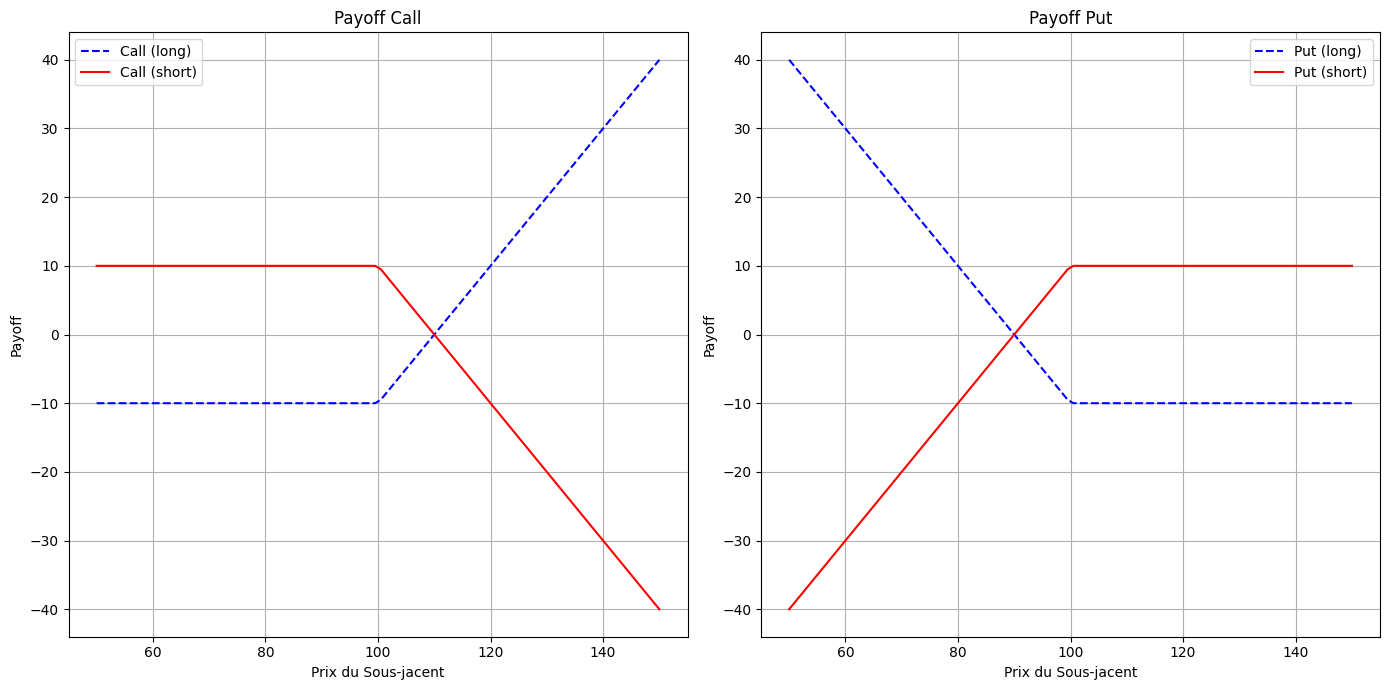

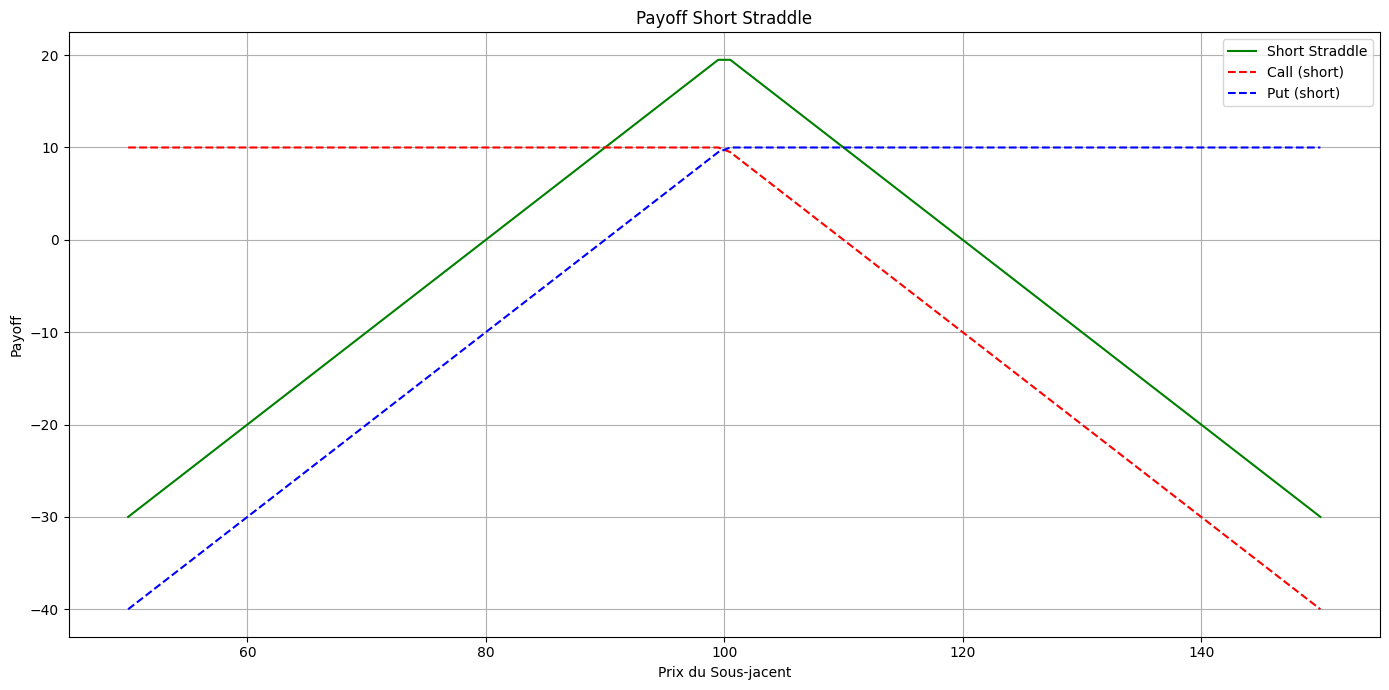

In [36]:
def call_payoff(s, k):
    return np.maximum(s - k, 0) - premium

def put_payoff(s, k):
    return np.maximum(k - s, 0) - premium

def short_call_payoff(s, k, premium):
    return - call_payoff(s, k)

def short_put_payoff(s, k, premium):
    return - put_payoff(s, k)

current_price = 100
strike_price = current_price
premium = 10  
prices = np.linspace(current_price * 0.5, current_price * 1.5, 100)

# Calculer les payoffs individuels
call_payoffs = call_payoff(prices, strike_price)
put_payoffs = put_payoff(prices, strike_price)
short_call_payoffs = short_call_payoff(prices, strike_price, premium)
short_put_payoffs = short_put_payoff(prices, strike_price, premium)

# Calculer le payoff du short straddle
short_straddle_payoffs = short_call_payoffs + short_put_payoffs

plt.figure(figsize=(14, 7))

plt.subplot(1, 2, 1)
plt.plot(prices, call_payoffs, label='Call (long)', color='blue', linestyle='--')
plt.plot(prices, short_call_payoffs, label='Call (short)', color='red')
plt.title('Payoff Call')
plt.xlabel('Prix du Sous-jacent')
plt.ylabel('Payoff')
plt.grid(True)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(prices, put_payoffs, label='Put (long)', color='blue', linestyle='--')
plt.plot(prices, short_put_payoffs, label='Put (short)', color='red')
plt.title('Payoff Put')
plt.xlabel('Prix du Sous-jacent')
plt.ylabel('Payoff')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

plt.figure(figsize=(14, 7))
plt.plot(prices, short_straddle_payoffs, label='Short Straddle', color='green')
plt.plot(prices, short_call_payoffs, label='Call (short)', color='red', linestyle='--')
plt.plot(prices, short_put_payoffs, label='Put (short)', color='blue', linestyle='--')
plt.title('Payoff Short Straddle')
plt.xlabel('Prix du Sous-jacent')
plt.ylabel('Payoff')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

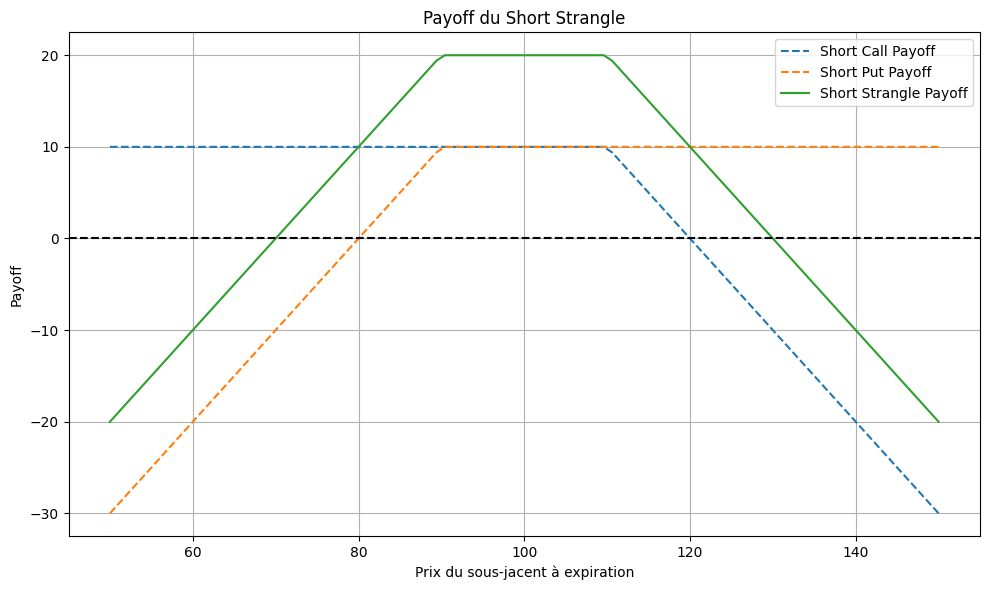

In [37]:
strike_price_call = current_price * 1.1  
strike_price_put = current_price * 0.9  

prices = np.linspace(current_price * 0.5, current_price * 1.5, 100)

call_payoffs = call_payoff(prices, strike_price_call)
put_payoffs = put_payoff(prices, strike_price_put)
short_call_payoffs = short_call_payoff(prices, strike_price_call, premium)
short_put_payoffs = short_put_payoff(prices, strike_price_put, premium)


short_strangle_payoffs = short_call_payoffs + short_put_payoffs


plt.figure(figsize=(10, 6))
plt.plot(prices, short_call_payoffs, label='Short Call Payoff', linestyle='--')
plt.plot(prices, short_put_payoffs, label='Short Put Payoff', linestyle='--')
plt.plot(prices, short_strangle_payoffs, label='Short Strangle Payoff', linestyle='-')
plt.axhline(0, color='black', linestyle='--')
plt.xlabel('Prix du sous-jacent à expiration')
plt.ylabel('Payoff')
plt.title('Payoff du Short Strangle')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Pricer B&S classique

In [38]:
# black scholes pricer pour le prix du straddle à chaque date
import numpy as np
from scipy.stats import norm
def black_scholes(S, K, T, r, sigma, option_type='call'):
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    
    if option_type == 'call':
        price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    elif option_type == 'put':
        price = K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)
    
    return price

# Paramètres
#S = 106.668
#K = S
#T = 30 / 365
r = 3.66 / 100
#sigma = df['Volatility'].iloc[-1] / 100

# Calcul du prix du straddle
#straddle_price = black_scholes(S, K, T, r, sigma, option_type='call') + black_scholes(S, K, T, r, sigma, option_type='put')
#print(f"Prix du straddle: {straddle_price}")

### Backtesting sur ces stratégégies :

In [39]:
def call_payoff(s, k):
    return np.maximum(s - k, 0)

def put_payoff(s, k):
    return np.maximum(k - s, 0)

def short_call_payoff(s, k, premium):
    return premium - call_payoff(s, k)

def short_put_payoff(s, k, premium):
    return premium - put_payoff(s, k)

def short_straddle_payoff(s, k, premium):
    return short_call_payoff(s, k, premium) + short_put_payoff(s, k, premium)

def short_strangle_payoff(s, k1, k2, premium):
    return short_call_payoff(s, k1, premium) + short_put_payoff(s, k2, premium)

     Open Date Close Date  Open Price  Close Price    Payoff   Premium
0   2023-01-02 2023-02-13      105.57       105.52       NaN       NaN
1   2023-01-03 2023-02-14      105.59       105.38       NaN       NaN
2   2023-01-04 2023-02-15      105.76       105.38       NaN       NaN
3   2023-01-05 2023-02-16      105.69       105.35       NaN       NaN
4   2023-01-06 2023-02-17      105.82       105.37       NaN       NaN
..         ...        ...         ...          ...       ...       ...
370 2024-06-03 2024-07-15      105.03       105.70 -0.038364  0.315818
371 2024-06-04 2024-07-16      105.08       105.79 -0.078025  0.315988
372 2024-06-05 2024-07-17      105.45       105.76  0.329314  0.319657
373 2024-06-06 2024-07-18      105.36       105.77  0.228766  0.319383
374 2024-06-07 2024-07-19      105.20       105.73  0.109417  0.319708

[375 rows x 6 columns]
Payoff total du short straddle sur la période: 77.2317571213942


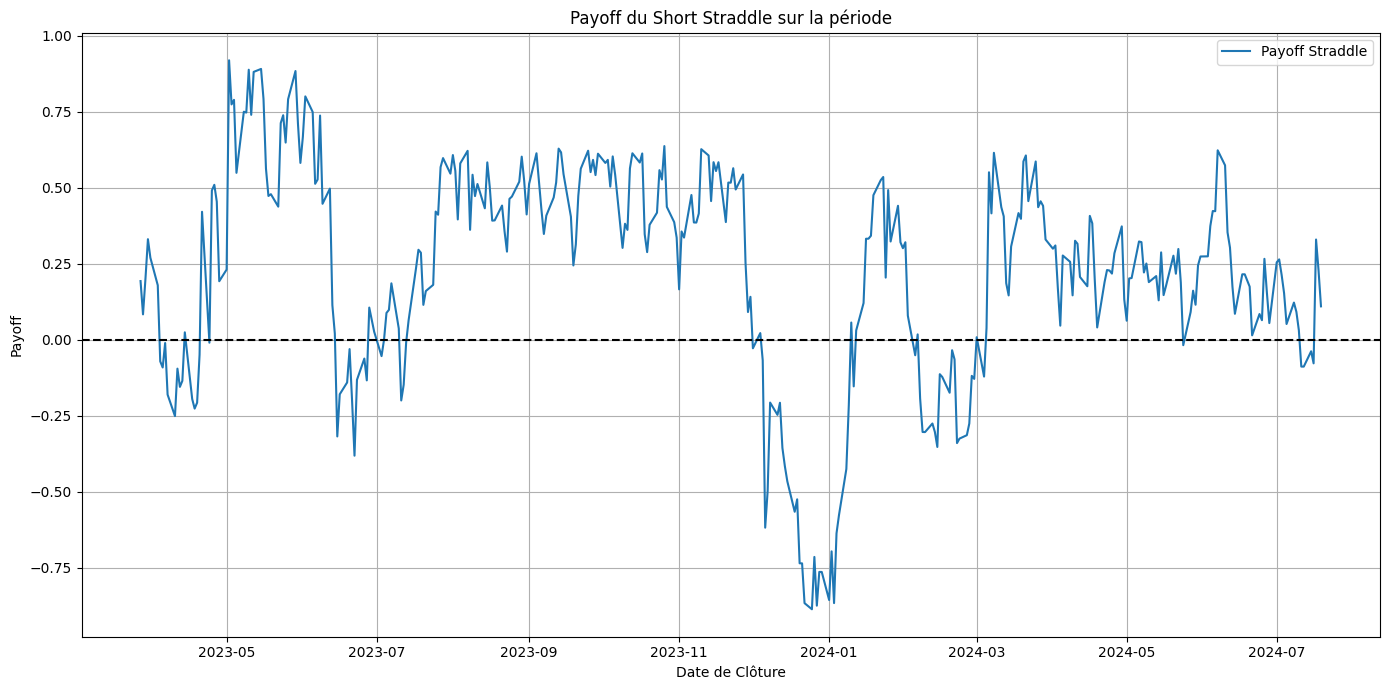

In [40]:
# Paramètres
straddle_days = 30  # durée en jours pour chaque position

results = []

for i in range(len(df) - straddle_days):
    # Date d'ouverture et de fermeture de la position
    open_date = df.iloc[i]['Date']
    close_date = df.iloc[i + straddle_days]['Date']
    
    # Prix du sous-jacent à l'ouverture et à la fermeture
    open_price = df.iloc[i]['Bid']
    close_price = df.iloc[i + straddle_days]['Bid']
    
    # Calcul du payoff pour un short straddle
    strike_price = open_price  # pour un straddle, on choisit le strike au prix du marché

    # on utilise ici le pricer la prime à l'instant t
    sigma = df['Volatility'].iloc[i] / 100
    premium_call = black_scholes(open_price, strike_price, straddle_days / 365, r, sigma, option_type='call')
    premium_put = black_scholes(open_price, strike_price, straddle_days / 365, r, sigma, option_type='put')
    premium = premium_call + premium_put

    payoff = short_straddle_payoff(close_price, strike_price, premium)
    
    results.append({
        'Open Date': open_date,
        'Close Date': close_date,
        'Open Price': open_price,
        'Close Price': close_price,
        'Payoff': payoff,
        'Premium': premium
    })

results_df = pd.DataFrame(results)
print(results_df)

total_payoff = results_df['Payoff'].sum()

print(f"Payoff total du short straddle sur la période: {total_payoff}")

plt.figure(figsize=(14, 7))
plt.plot(results_df['Close Date'], results_df['Payoff'], label='Payoff Straddle')
plt.axhline(0, color='black', linestyle='--')
plt.xlabel('Date de Clôture')
plt.ylabel('Payoff')
plt.title('Payoff du Short Straddle sur la période')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

     Open Date Close Date  Open Price  Close Price    Payoff   Premium
0   2023-01-02 2023-02-13      105.57       105.52       NaN       NaN
1   2023-01-03 2023-02-14      105.59       105.38       NaN       NaN
2   2023-01-04 2023-02-15      105.76       105.38       NaN       NaN
3   2023-01-05 2023-02-16      105.69       105.35       NaN       NaN
4   2023-01-06 2023-02-17      105.82       105.37       NaN       NaN
..         ...        ...         ...          ...       ...       ...
370 2024-06-03 2024-07-15      105.03       105.70 -0.216139  0.126930
371 2024-06-04 2024-07-16      105.08       105.79 -0.255494  0.127253
372 2024-06-05 2024-07-17      105.45       105.76  0.168280  0.139140
373 2024-06-06 2024-07-18      105.36       105.77  0.067776  0.138888
374 2024-06-07 2024-07-19      105.20       105.73 -0.048989  0.140505

[375 rows x 6 columns]
Payoff total du short strangle sur la période: 13.700415943182726


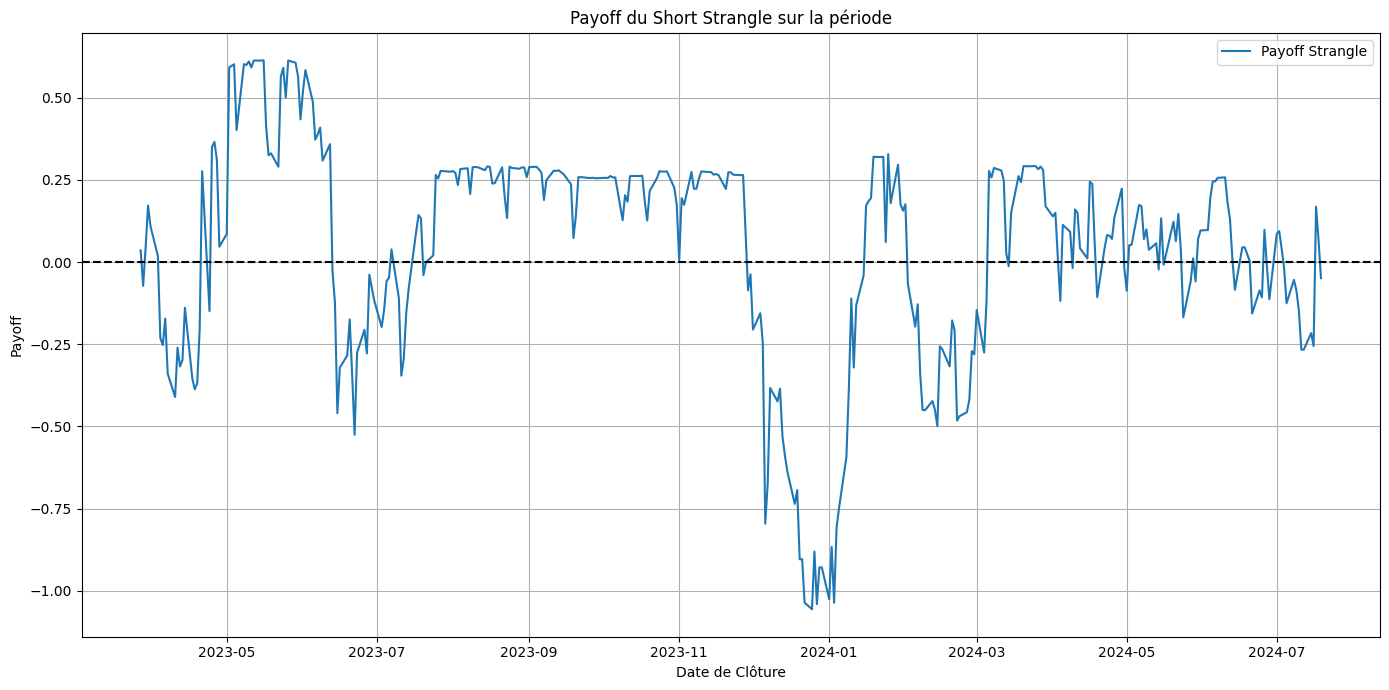

In [41]:
# Short Strangle 
strangle_days = 30 

strangle_results = []

for i in range(len(df) - strangle_days):
    # Date d'ouverture et de fermeture de la position
    open_date = df.iloc[i]['Date']
    close_date = df.iloc[i + strangle_days]['Date']
    
    # Prix du sous-jacent à l'ouverture et à la fermeture
    open_price = df.iloc[i]['Bid']
    close_price = df.iloc[i + strangle_days]['Bid']
    
    # Définir les strikes pour le strangle
    strike_price_call = open_price + 0.20  # Strike pour le call (ajouter 20 ticks)
    strike_price_put = open_price - 0.20   # Strike pour le put (soustraire 20 ticks)
    
    # Calculer les primes
    sigma = df['Volatility'].iloc[i] / 100
    premium_call = black_scholes(open_price, strike_price_call, strangle_days / 365, r, sigma, option_type='call')
    premium_put = black_scholes(open_price, strike_price_put, strangle_days / 365, r, sigma, option_type='put')
    premium = premium_call + premium_put

    # Calculer le payoff du short strangle
    payoff = short_strangle_payoff(close_price, strike_price_call, strike_price_put, premium)
    
    strangle_results.append({
        'Open Date': open_date,
        'Close Date': close_date,
        'Open Price': open_price,
        'Close Price': close_price,
        'Payoff': payoff,
        'Premium': premium
    })

strangle_results_df = pd.DataFrame(strangle_results)
print(strangle_results_df)


# strangle_results_df.to_csv('strangle_results.csv')

total_strangle_payoff = strangle_results_df['Payoff'].sum()

print(f"Payoff total du short strangle sur la période: {total_strangle_payoff}")

plt.figure(figsize=(14, 7))
plt.plot(strangle_results_df['Close Date'], strangle_results_df['Payoff'], label='Payoff Strangle')
plt.axhline(0, color='black', linestyle='--')
plt.xlabel('Date de Clôture')
plt.ylabel('Payoff')
plt.title('Payoff du Short Strangle sur la période')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
